In [1]:
import yfinance as yf
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
import random
from datetime import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import warnings
import tensorflow as tf
import random

warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Prepare Dataset

In [ ]:
# Data Download Configuration
# S&P 500: January 1, 2002 to December 31, 2023
# Bitcoin: January 1, 2015 to December 31, 2023

# Define date ranges
sp500_start = "2002-01-01"
sp500_end = "2023-12-31"
bitcoin_start = "2015-01-01"
bitcoin_end = "2023-12-31"

print("Downloading S&P 500 data...")
sp500_data = yf.download("^GSPC", start=sp500_start, end=sp500_end, progress=False)

print("Downloading Bitcoin data...")
bitcoin_data = yf.download("BTC-USD", start=bitcoin_start, end=bitcoin_end, progress=False)

# Display basic information about downloaded data
print(f"\nS&P 500 Data Shape: {sp500_data.shape}")
print(f"S&P 500 Date Range: {sp500_data.index.min()} to {sp500_data.index.max()}")
print(f"Total S&P 500 observations: {len(sp500_data)}")

print(f"\nBitcoin Data Shape: {bitcoin_data.shape}")
print(f"Bitcoin Date Range: {bitcoin_data.index.min()} to {bitcoin_data.index.max()}")
print(f"Total Bitcoin observations: {len(bitcoin_data)}")

sp500_data.columns = sp500_data.columns.set_levels(['Adj Close' if x == 'Close' else x for x in sp500_data.columns.levels[0]], level=0)

bitcoin_data.columns = bitcoin_data.columns.set_levels(['Adj Close' if x == 'Close' else x for x in bitcoin_data.columns.levels[0]], level=0)


print("\nVerification - S&P 500 has Adj Close:", ('Adj Close', '^GSPC') in sp500_data.columns)
print("Verification - Bitcoin has Adj Close:", ('Adj Close', 'BTC-USD') in bitcoin_data.columns)


S&P 500 Data Shape: (5537, 5)
S&P 500 Date Range: 2002-01-02 00:00:00 to 2023-12-29 00:00:00
Total S&P 500 observations: 5537

Bitcoin Data Shape: (3286, 5)
Bitcoin Date Range: 2015-01-01 00:00:00 to 2023-12-30 00:00:00
Total Bitcoin observations: 3286

Verification - S&P 500 has Adj Close: True
Verification - Bitcoin has Adj Close: True


In [3]:
sp500_data['Log_Returns'] = np.log(sp500_data['Adj Close'] / sp500_data['Adj Close'].shift(1))

bitcoin_data['Log_Returns'] = np.log(bitcoin_data['Adj Close'] / bitcoin_data['Adj Close'].shift(1))

sp500_clean = sp500_data.dropna()
bitcoin_clean = bitcoin_data.dropna()


In [4]:
statistics_data = {
    'Observations': [len(sp500_clean), len(bitcoin_clean)],
    'Mean_Daily_Return': [sp500_clean['Log_Returns'].mean(), bitcoin_clean['Log_Returns'].mean()],
    'Standard_Deviation': [sp500_clean['Log_Returns'].std(), bitcoin_clean['Log_Returns'].std()],
    'Minimum_Return': [sp500_clean['Log_Returns'].min(), bitcoin_clean['Log_Returns'].min()],
    'Maximum_Return': [sp500_clean['Log_Returns'].max(), bitcoin_clean['Log_Returns'].max()],
    'Skewness': [sp500_clean['Log_Returns'].skew(), bitcoin_clean['Log_Returns'].skew()],
    'Kurtosis': [sp500_clean['Log_Returns'].kurtosis(), bitcoin_clean['Log_Returns'].kurtosis()],
    'Infinite_Values': [np.isinf(sp500_clean['Log_Returns']).sum(), np.isinf(bitcoin_clean['Log_Returns']).sum()],
    'NaN_Values': [sp500_clean['Log_Returns'].isnull().sum(), bitcoin_clean['Log_Returns'].isnull().sum()]
}

# Create DataFrame with asset names as index
returns_statistics = pd.DataFrame(statistics_data, index=['S&P_500', 'Bitcoin'])

returns_statistics.T


,S&P_500,Bitcoin
Observations,5536.000000,3285.000000
Mean_Daily_Return,0.000256,0.001491
Standard_Deviation,0.012245,0.037394
Minimum_Return,-0.127652,-0.464730
Maximum_Return,0.109572,0.225119
Skewness,-0.423037,-0.793774
Kurtosis,11.499578,11.618614
Infinite_Values,0.000000,0.000000
NaN_Values,0.000000,0.000000


=== FINAL DATA VERIFICATION ===



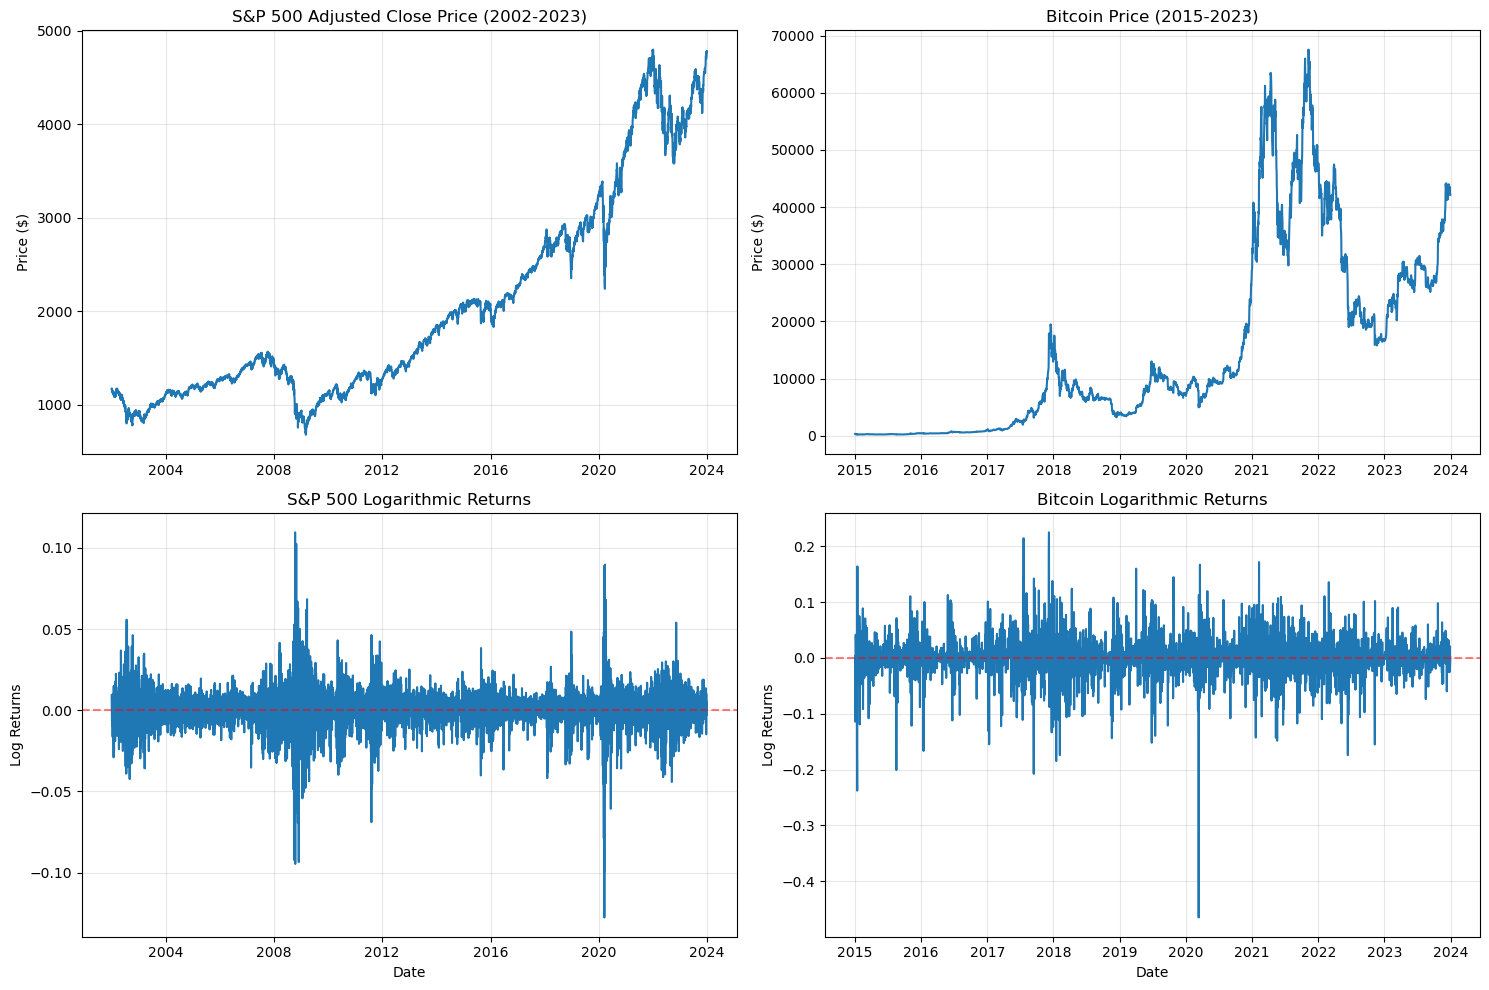


=== SAMPLE DATA PREVIEW ===

S&P 500 Data (First 5 rows):
Price              Open         High          Low    Adj Close      Volume Log_Returns
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC            
Date                                                                                  
2002-01-03  1154.670044  1165.270020  1154.010010  1165.270020  1398900000    0.009138
2002-01-04  1165.270020  1176.550049  1163.420044  1172.510010  1513000000    0.006194
2002-01-07  1172.510010  1176.969971  1163.550049  1164.890015  1308300000   -0.006520
2002-01-08  1164.890015  1167.599976  1157.459961  1160.709961  1258800000   -0.003595
2002-01-09  1160.709961  1174.260010  1151.890015  1155.140015  1452000000   -0.004810

Bitcoin Data (First 5 rows):
Price             Open        High         Low   Adj Close    Volume Log_Returns
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD            
Date                                                 

In [5]:
# Data Visualization and Final Verification

print("=== FINAL DATA VERIFICATION ===\n")

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# S&P 500 Price Series
ax1.plot(sp500_clean.index, sp500_clean['Adj Close'])
ax1.set_title('S&P 500 Adjusted Close Price (2002-2023)')
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)

# Bitcoin Price Series
ax2.plot(bitcoin_clean.index, bitcoin_clean['Adj Close'])
ax2.set_title('Bitcoin Price (2015-2023)')
ax2.set_ylabel('Price ($)')
ax2.grid(True, alpha=0.3)

# S&P 500 Log Returns
ax3.plot(sp500_clean.index, sp500_clean['Log_Returns'])
ax3.set_title('S&P 500 Logarithmic Returns')
ax3.set_ylabel('Log Returns')
ax3.set_xlabel('Date')
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax3.grid(True, alpha=0.3)

# Bitcoin Log Returns
ax4.plot(bitcoin_clean.index, bitcoin_clean['Log_Returns'])
ax4.set_title('Bitcoin Logarithmic Returns')
ax4.set_ylabel('Log Returns')
ax4.set_xlabel('Date')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display sample data
print("\n=== SAMPLE DATA PREVIEW ===\n")
print("S&P 500 Data (First 5 rows):")
print(sp500_clean[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Log_Returns']].head())

print("\nBitcoin Data (First 5 rows):")
print(bitcoin_clean[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Log_Returns']].head())



Stationary Test

ADF Statistic: -18.553729
p-value: 0.000000


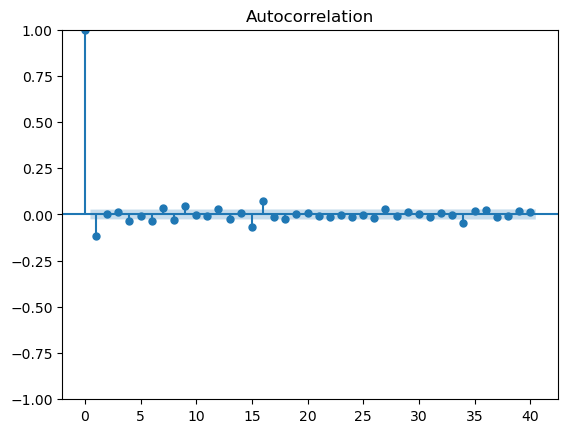

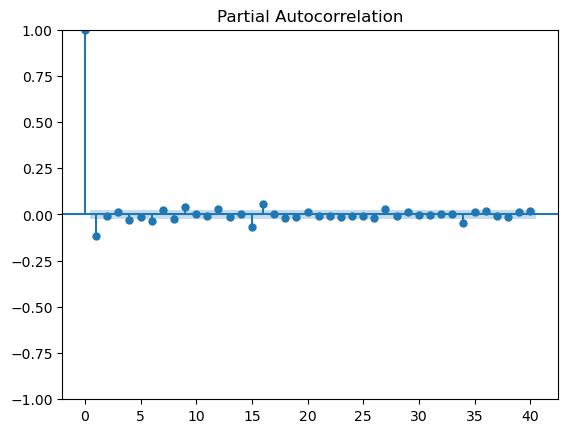

In [6]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


sp500_adf_test = adfuller(sp500_clean['Log_Returns'])
# Output the results
print('ADF Statistic: %f' % sp500_adf_test[0])
print('p-value: %f' % sp500_adf_test[1])

plot_acf(sp500_clean['Log_Returns'], lags=40)
plot_pacf(sp500_clean['Log_Returns'], lags=40)
plt.show()

ADF Statistic: -58.553594
p-value: 0.000000


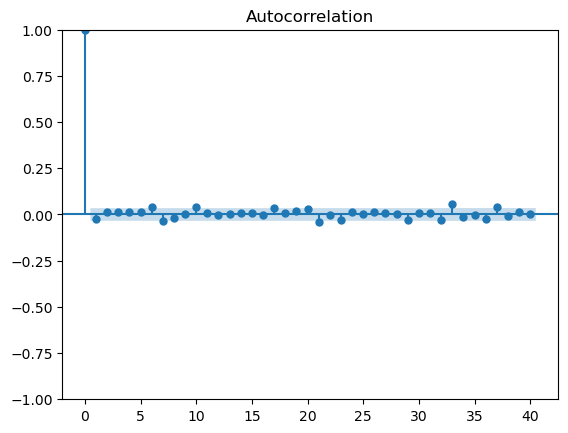

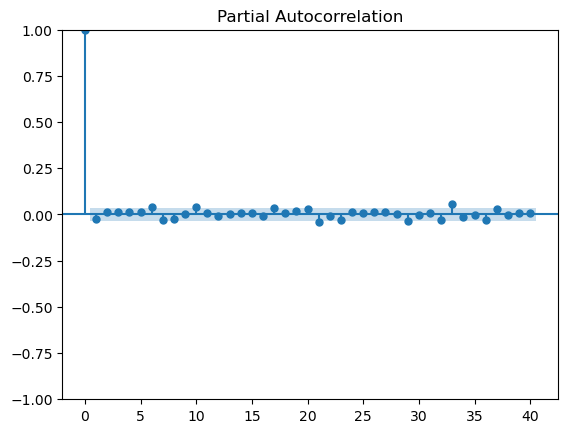

In [7]:
bitcoin_adf_test = adfuller(bitcoin_clean['Log_Returns'])
# Output the results
print('ADF Statistic: %f' % bitcoin_adf_test[0])
print('p-value: %f' % bitcoin_adf_test[1])

plot_acf(bitcoin_clean['Log_Returns'], lags=40)
plot_pacf(bitcoin_clean['Log_Returns'], lags=40)
plt.show()

# Cross Validation

In [ ]:
# Time Series Cross-Validation Implementation
# Novel 3-fold cross-validation scheme with rolling windows

import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# print("=== TIME SERIES CROSS-VALIDATION IMPLEMENTATION ===\n")

def create_sp500_cv_splits(data, start_date=None):
    
    if start_date is None:
        start_date = data.index.min()
    
    cv_splits = []
    window_start = start_date
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=3) - timedelta(days=1)
        
        # Validation periods (8, 16, 24 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=8) - timedelta(days=1)  # 8 months
        val2_end = val_start + relativedelta(months=16) - timedelta(days=1) # 16 months  
        val3_end = val_start + relativedelta(months=24) - timedelta(days=1) # 24 months (2 years)
        
        # Test period (1 year)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(years=1) - timedelta(days=1)

        if test_end.year > 2024:
            break
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 8
                },
                {
                    'fold': 2, 
                    'data': val2_data,
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 16
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 24
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 1 year
        window_start += relativedelta(years=1)
    
    return cv_splits

def create_bitcoin_cv_splits(data, start_date=None):
    
    if start_date is None:
        # Start from a date that allows for proper window construction
        start_date = datetime(2015, 1, 1)
    
    cv_splits = []
    window_start = start_date
    
    # Define the testing period constraint
    test_period_start = datetime(2018, 1, 1)
    test_period_end = datetime(2023, 12, 31)
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=2) - timedelta(days=1)
        
        # Validation periods (4, 8, 12 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=4) - timedelta(days=1)  # 4 months
        val2_end = val_start + relativedelta(months=8) - timedelta(days=1)  # 8 months
        val3_end = val_start + relativedelta(months=12) - timedelta(days=1) # 12 months
        
        # Test period (6 months)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(months=6) - timedelta(days=1)
        
        # Check constraints
        # if test_end > data.index.max() or test_end > test_period_end:
        #     break
        if test_end.year > 2023:
            break
        
        # Only include windows where test period is within 2018-2023
        if test_start < test_period_start:
            window_start += relativedelta(months=6)
            continue
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 4
                },
                {
                    'fold': 2,
                    'data': val2_data, 
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 8
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 12
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 6 months
        window_start += relativedelta(months=6)
    
    return cv_splits



In [ ]:
# Apply Cross-Validation Schemes to Data

print("=== GENERATING CROSS-VALIDATION SPLITS ===\n")

# Generate S&P 500 cross-validation splits
sp500_cv_splits = create_sp500_cv_splits(sp500_clean)


# Generate Bitcoin cross-validation splits  
bitcoin_cv_splits = create_bitcoin_cv_splits(bitcoin_clean)


# Create summary DataFrames
def create_cv_summary(cv_splits, asset_name):
    """Create a summary DataFrame for cross-validation splits"""
    summary_data = []
    
    for split in cv_splits:
        # Add training data info
        summary_data.append({
            'Asset': asset_name,
            'Window_ID': split['window_id'],
            'Split_Type': 'Train',
            'Fold': 'N/A',
            'Start_Date': split['train']['start'].strftime('%Y-%m-%d'),
            'End_Date': split['train']['end'].strftime('%Y-%m-%d'),
            'Size': split['train']['size'],
            'Duration_Months': 'N/A'
        })
        
        # Add validation data info
        for val_fold in split['validation']:
            summary_data.append({
                'Asset': asset_name,
                'Window_ID': split['window_id'],
                'Split_Type': 'Validation',
                'Fold': val_fold['fold'],
                'Start_Date': val_fold['start'].strftime('%Y-%m-%d'),
                'End_Date': val_fold['end'].strftime('%Y-%m-%d'),
                'Size': val_fold['size'],
                'Duration_Months': val_fold['months']
            })
        
        # Add test data info
        summary_data.append({
            'Asset': asset_name,
            'Window_ID': split['window_id'],
            'Split_Type': 'Test',
            'Fold': 'N/A',
            'Start_Date': split['test']['start'].strftime('%Y-%m-%d'),
            'End_Date': split['test']['end'].strftime('%Y-%m-%d'),
            'Size': split['test']['size'],
            'Duration_Months': 'N/A'
        })
    
    return pd.DataFrame(summary_data)

# Create summary DataFrames
sp500_cv_summary = create_cv_summary(sp500_cv_splits, 'S&P_500')
bitcoin_cv_summary = create_cv_summary(bitcoin_cv_splits, 'Bitcoin')

# Combined summary
cv_summary_combined = pd.concat([sp500_cv_summary, bitcoin_cv_summary], ignore_index=True)

print("\n=== S&P 500 CV WINDOWS (First set) ===")
for i, split in enumerate(sp500_cv_splits[:1]):
    print(f"\nWindow {split['window_id']}:")
    print(f"  Train: {split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
    print(f"  Validation Folds:")
    for val_fold in split['validation']:
        print(f"    Fold {val_fold['fold']} ({val_fold['months']}mo): {val_fold['start'].strftime('%Y-%m-%d')} to {val_fold['end'].strftime('%Y-%m-%d')} ({val_fold['size']} obs)")
    print(f"  Test: {split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")

print("\n=== BITCOIN CV WINDOWS (First set) ===")
for i, split in enumerate(bitcoin_cv_splits[:1]):
    print(f"\nWindow {split['window_id']}:")
    print(f"  Train: {split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
    print(f"  Validation Folds:")
    for val_fold in split['validation']:
        print(f"    Fold {val_fold['fold']} ({val_fold['months']}mo): {val_fold['start'].strftime('%Y-%m-%d')} to {val_fold['end'].strftime('%Y-%m-%d')} ({val_fold['size']} obs)")
    print(f"  Test: {split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")

# Display summary statistics
print("\n=== CV SPLIT STATISTICS ===")
split_stats = cv_summary_combined.groupby(['Asset', 'Split_Type']).agg({
    'Size': ['mean', 'std', 'min', 'max'],
    'Window_ID': 'count'
}).round(0)
print(split_stats)


=== GENERATING CROSS-VALIDATION SPLITS ===


=== S&P 500 CV WINDOWS (First set) ===

Window 1:
  Train: 2002-01-03 to 2005-01-02 (755 obs)
  Validation Folds:
    Fold 1 (8mo): 2005-01-03 to 2005-09-02 (170 obs)
    Fold 2 (16mo): 2005-01-03 to 2006-05-02 (335 obs)
    Fold 3 (24mo): 2005-01-03 to 2007-01-02 (503 obs)
  Test: 2007-01-03 to 2008-01-02 (252 obs)

=== BITCOIN CV WINDOWS (First set) ===

Window 1:
  Train: 2015-01-01 to 2016-12-31 (730 obs)
  Validation Folds:
    Fold 1 (4mo): 2017-01-01 to 2017-04-30 (120 obs)
    Fold 2 (8mo): 2017-01-01 to 2017-08-31 (243 obs)
    Fold 3 (12mo): 2017-01-01 to 2017-12-31 (365 obs)
  Test: 2018-01-01 to 2018-06-30 (181 obs)

=== CV SPLIT STATISTICS ===
                     Size                  Window_ID
                     mean    std  min  max     count
Asset   Split_Type                                  
Bitcoin Test        182.0    1.0  181  184        12
        Train       730.0    1.0  730  731        12
        Validation  243.0

In [ ]:
def plot_cv_timeline(cv_splits, asset_name, max_windows=8):
    """Create a timeline visualization of the cross-validation scheme"""
    
    fig, ax = plt.subplots(figsize=(16, max(6, len(cv_splits[:max_windows]) * 1.5)))
    
    colors = {
        'train': '#2E8B57', 
        'val_fold1': '#4169E1',  
        'val_fold2': '#1E90FF',  
        'val_fold3': '#87CEEB',  
        'test': '#DC143C'        
    }
    
    y_positions = []
    
    for i, split in enumerate(cv_splits[:max_windows]):
        y_pos = len(cv_splits[:max_windows]) - i - 1
        y_positions.append(y_pos)
        
        # Plot training period
        ax.barh(y_pos, (split['train']['end'] - split['train']['start']).days, 
                left=split['train']['start'], height=0.6, 
                color=colors['train'], alpha=0.8, label='Train' if i == 0 else "")
        
        # Plot validation periods
        val_colors = ['val_fold1', 'val_fold2', 'val_fold3']
        for j, val_fold in enumerate(split['validation']):
            ax.barh(y_pos + 0.1 + j*0.15, (val_fold['end'] - val_fold['start']).days,
                    left=val_fold['start'], height=0.12,
                    color=colors[val_colors[j]], alpha=0.8,
                    label=f'Val Fold {j+1} ({val_fold["months"]}mo)' if i == 0 else "")
        
        # Plot test period
        ax.barh(y_pos, (split['test']['end'] - split['test']['start']).days,
                left=split['test']['start'], height=0.6,
                color=colors['test'], alpha=0.8, label='Test' if i == 0 else "")
        
        # Add window labels
        ax.text(split['train']['start'], y_pos, f'W{split["window_id"]}',
                verticalalignment='center', fontsize=9, fontweight='bold')
    
    # Formatting
    ax.set_ylim(-0.5, len(cv_splits[:max_windows]) - 0.5)
    ax.set_ylabel('CV Windows (Newest to Oldest)', fontsize=12)
    ax.set_xlabel('Time Period', fontsize=12)
    ax.set_title(f'{asset_name} Cross-Validation Timeline\n({len(cv_splits)} Total Windows, Showing First {min(max_windows, len(cv_splits))})', 
                fontsize=14, fontweight='bold')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=True, fancybox=True, shadow=True)
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return fig, ax

print("=== CROSS-VALIDATION SCHEME VISUALIZATION ===\n")


def create_cv_comparison_chart():
    """Create a side-by-side comparison of CV schemes"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # S&P 500 scheme visualization
    y_pos = 1
    
    # S&P 500 scheme
    ax1.barh(y_pos, 3*365, left=0, height=0.6, color='#2E8B57', alpha=0.8, label='Train (3yr)')
    ax1.barh(y_pos+0.1, 8*30, left=3*365, height=0.15, color='#4169E1', alpha=0.8, label='Val Fold 1 (8mo)')
    ax1.barh(y_pos+0.25, 16*30, left=3*365, height=0.15, color='#1E90FF', alpha=0.8, label='Val Fold 2 (16mo)')
    ax1.barh(y_pos+0.4, 24*30, left=3*365, height=0.15, color='#87CEEB', alpha=0.8, label='Val Fold 3 (24mo)')
    ax1.barh(y_pos, 1*365, left=5*365, height=0.6, color='#DC143C', alpha=0.8, label='Test (1yr)')
    
    ax1.set_xlim(0, 6*365)
    ax1.set_ylim(0.5, 1.8)
    ax1.set_xlabel('Days')
    ax1.set_title('S&P 500 CV Scheme\n(6-year windows)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bitcoin scheme
    ax2.barh(y_pos, 2*365, left=0, height=0.6, color='#2E8B57', alpha=0.8, label='Train (2yr)')
    ax2.barh(y_pos+0.1, 4*30, left=2*365, height=0.15, color='#4169E1', alpha=0.8, label='Val Fold 1 (4mo)')
    ax2.barh(y_pos+0.25, 8*30, left=2*365, height=0.15, color='#1E90FF', alpha=0.8, label='Val Fold 2 (8mo)')
    ax2.barh(y_pos+0.4, 12*30, left=2*365, height=0.15, color='#87CEEB', alpha=0.8, label='Val Fold 3 (12mo)')
    ax2.barh(y_pos, 6*30, left=3*365, height=0.6, color='#DC143C', alpha=0.8, label='Test (6mo)')
    
    ax2.set_xlim(0, 3.5*365)
    ax2.set_ylim(0.5, 1.8)
    ax2.set_xlabel('Days')
    ax2.set_title('Bitcoin CV Scheme\n(~3.5-year windows)', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Time Series Cross-Validation Scheme Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

cv_scheme_summary = pd.DataFrame({
    'Asset': ['S&P 500', 'Bitcoin'],
    'Total_Windows': [len(sp500_cv_splits), len(bitcoin_cv_splits)],
    'Window_Length': ['6 years', '~3.5 years'],
    'Train_Period': ['3 years', '2 years'],
    'Validation_Folds': ['8/16/24 months', '4/8/12 months'],
    'Test_Period': ['1 year', '6 months'],
    'Window_Shift': ['1 year', '6 months'],
    'Test_Coverage': [
        f"{sp500_cv_splits[0]['test']['start'].strftime('%Y-%m-%d')} to {sp500_cv_splits[-1]['test']['end'].strftime('%Y-%m-%d')}",
        f"{bitcoin_cv_splits[0]['test']['start'].strftime('%Y-%m-%d')} to {bitcoin_cv_splits[-1]['test']['end'].strftime('%Y-%m-%d')}"
    ]
})




=== CROSS-VALIDATION SCHEME VISUALIZATION ===



In [ ]:
# Utility Functions for Cross-Validation Data Access

def get_cv_data(cv_splits, window_id, fold=None, return_type='data'):
    split = next((s for s in cv_splits if s['window_id'] == window_id), None)
    if split is None:
        raise ValueError(f"Window ID {window_id} not found")
    
    if return_type == 'train':
        return split['train']['data']
    elif return_type == 'test':
        return split['test']['data']
    elif return_type == 'validation':
        if fold is None:
            raise ValueError("Fold number must be specified for validation data")
        if fold not in [1, 2, 3]:
            raise ValueError("Fold must be 1, 2, or 3")
        return split['validation'][fold-1]['data']
    else:
        return split

# Example usage functions
def demonstrate_cv_usage():
    
    # Example 1: Get training data from first S&P 500 window
    train_data_sp500 = get_cv_data(sp500_cv_splits, window_id=1, return_type='train')
    print(f"S&P 500 Window 1 - Training data shape: {train_data_sp500.shape}")
    print(f"Training period: {train_data_sp500.index.min()} to {train_data_sp500.index.max()}")
    
    # Example 2: Get validation fold 2 data from first S&P 500 window  
    val_data_sp500 = get_cv_data(sp500_cv_splits, window_id=1, fold=2, return_type='validation')
    print(f"\nS&P 500 Window 1 - Validation Fold 2 shape: {val_data_sp500.shape}")
    print(f"Validation period: {val_data_sp500.index.min()} to {val_data_sp500.index.max()}")
    
    # Example 3: Get test data from first Bitcoin window
    test_data_bitcoin = get_cv_data(bitcoin_cv_splits, window_id=1, return_type='test')
    print(f"\nBitcoin Window 1 - Test data shape: {test_data_bitcoin.shape}")
    print(f"Test period: {test_data_bitcoin.index.min()} to {test_data_bitcoin.index.max()}")
    
    return train_data_sp500, val_data_sp500, test_data_bitcoin

# Run demonstration
sample_train, sample_val, sample_test = demonstrate_cv_usage()


# Save CV splits for later use (optional)
cv_implementation_summary = {
    'sp500_cv_splits': sp500_cv_splits,
    'bitcoin_cv_splits': bitcoin_cv_splits,
    'sp500_summary': sp500_cv_summary,
    'bitcoin_summary': bitcoin_cv_summary,
    'combined_summary': cv_summary_combined,
    'scheme_comparison': cv_scheme_summary
}



=== CROSS-VALIDATION DATA ACCESS EXAMPLES ===

S&P 500 Window 1 - Training data shape: (755, 6)
Training period: 2002-01-03 00:00:00 to 2004-12-31 00:00:00

S&P 500 Window 1 - Validation Fold 2 shape: (335, 6)
Validation period: 2005-01-03 00:00:00 to 2006-05-02 00:00:00

Bitcoin Window 1 - Test data shape: (181, 6)
Test period: 2018-01-01 00:00:00 to 2018-06-30 00:00:00

TIME SERIES CROSS-VALIDATION IMPLEMENTATION COMPLETE

✓ IMPLEMENTATION SUMMARY:

📊 S&P 500 Cross-Validation Scheme:
   • 17 rolling windows of 6 years each
   • Training: 3 years | Validation: 2 years (3 folds) | Test: 1 year
   • Validation folds: 8, 16, and 24 months
   • Window advancement: 1 year forward

📈 Bitcoin Cross-Validation Scheme:
   • 12 rolling windows of ~3.5 years each  
   • Training: 2 years | Validation: 1 year (3 folds) | Test: 6 months
   • Validation folds: 4, 8, and 12 months
   • Window advancement: 6 months forward
   • Test period constraint: 2018-2023

🔧 Key Features:
   • Prevents data lea

# ARIMA-SVM HYBRID METHOD 2 (Non-additive)

## ARIMA

In [ ]:
# ARIMA Model Implementation with AIC-based Selection
# Modern approach replacing traditional Box-Jenkins methodology

import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import time

# Suppress convergence warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

def find_optimal_arima_order(data, max_p=5, max_d=2, max_q=5, seasonal=False, 
                           information_criterion='aic', verbose=False):
    best_ic = np.inf
    best_params = None
    best_model = None
    results_log = []
    
    # Create parameter grid
    if seasonal:
        # For seasonal ARIMA (not implemented in this study)
        param_grid = itertools.product(range(max_p+1), range(max_d+1), range(max_q+1),
                                     range(2), range(2), range(2), [12])
    else:
        # Standard ARIMA grid search
        param_grid = itertools.product(range(max_p+1), range(max_d+1), range(max_q+1))
    
    total_combinations = (max_p+1) * (max_d+1) * (max_q+1)
    
    if verbose:
        print(f"Testing {total_combinations} ARIMA parameter combinations...")
        start_time = time.time()
    
    for i, params in enumerate(param_grid):
        p, d, q = params[:3]
        
        # Skip if model is too simple (all parameters zero)
        if p == 0 and d == 0 and q == 0:
            continue
            
        try:
            # Fit ARIMA model
            model = ARIMA(data, order=(p, d, q))
            fitted_model = model.fit()
            
            # Get information criterion value
            if information_criterion.lower() == 'aic':
                ic_value = fitted_model.aic
            elif information_criterion.lower() == 'bic':
                ic_value = fitted_model.bic  
            elif information_criterion.lower() == 'hqic':
                ic_value = fitted_model.hqic
            else:
                ic_value = fitted_model.aic
            
            # Store results
            results_log.append({
                'order': (p, d, q),
                'aic': fitted_model.aic,
                'bic': fitted_model.bic,
                'hqic': fitted_model.hqic,
                'llf': fitted_model.llf,
                'converged': fitted_model.mle_retvals['converged'] if hasattr(fitted_model, 'mle_retvals') else True
            })
            
            # Update best model if current is better
            if ic_value < best_ic:
                best_ic = ic_value
                best_params = (p, d, q)
                best_model = fitted_model
                
        except Exception as e:
            # Log failed fits
            results_log.append({
                'order': (p, d, q),
                'aic': np.nan,
                'bic': np.nan,  
                'hqic': np.nan,
                'llf': np.nan,
                'converged': False,
                'error': str(e)
            })
            
            if verbose and i % 10 == 0:
                print(f"Failed to fit ARIMA{params}: {str(e)[:50]}...")
                
        if verbose and (i + 1) % 20 == 0:
            elapsed = time.time() - start_time
            progress = (i + 1) / total_combinations * 100
            print(f"Progress: {progress:.1f}% ({i+1}/{total_combinations}) | "
                  f"Best so far: ARIMA{best_params} ({information_criterion.upper()}={best_ic:.4f})")
    
    if verbose:
        total_time = time.time() - start_time
        print(f"\nGrid search completed in {total_time:.2f} seconds")
        print(f"Best model: ARIMA{best_params} with {information_criterion.upper()}={best_ic:.4f}")
    
    # Create results summary
    results_df = pd.DataFrame(results_log)
    successful_fits = results_df[results_df['converged'] == True]
    
    return {
        'best_order': best_params,
        'best_model': best_model,
        'best_ic_value': best_ic,
        'information_criterion': information_criterion,
        'results_df': results_df,
        'successful_fits': len(successful_fits),
        'total_attempts': len(results_log),
        'success_rate': len(successful_fits) / len(results_log) * 100
    }

def evaluate_arima_model(model, train_data, test_data, model_order):
    # Generate forecasts
    n_forecast = len(test_data)
    forecast_result = model.get_forecast(steps=n_forecast)
    forecasts = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    
    # Calculate performance metrics
    mse = mean_squared_error(test_data, forecasts)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, forecasts)
    mape = np.mean(np.abs((test_data - forecasts) / test_data)) * 100
    
    # Calculate R² score for fair comparison with SVM
    ss_res = np.sum((test_data - forecasts) ** 2)
    ss_tot = np.sum((test_data - np.mean(test_data)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # Direction accuracy (for returns)
    direction_actual = np.sign(test_data.values[1:])
    direction_forecast = np.sign(forecasts.values[1:])
    direction_accuracy = np.mean(direction_actual == direction_forecast) * 100
    
    # Residual diagnostics
    residuals = model.resid
    
    # Ljung-Box test for serial correlation in residuals
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=False)
    
    # Normality test (Jarque-Bera)
    jb_stat, jb_pvalue = stats.jarque_bera(residuals)
    
    # Heteroskedasticity test (simple approach)
    residuals_squared = residuals ** 2
    arch_stat, arch_pvalue = acorr_ljungbox(residuals_squared, lags=5, return_df=False)
    
    return {
        'model_order': model_order,
        'forecasts': forecasts,
        'forecast_ci': forecast_ci,
        'performance_metrics': {
            'mse': mse,
            'rmse': rmse, 
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'direction_accuracy': direction_accuracy
        },
        'diagnostic_tests': {
            'ljung_box_stat': lb_test['lb_stat'].iloc[-1],
            'ljung_box_pvalue': lb_test['lb_pvalue'].iloc[-1],
            'jarque_bera_stat': jb_stat,
            'jarque_bera_pvalue': jb_pvalue,
            'arch_stat': arch_stat[-1] if isinstance(arch_stat, np.ndarray) else arch_stat,
            'arch_pvalue': arch_pvalue[-1] if isinstance(arch_pvalue, np.ndarray) else arch_pvalue
        },
        'residuals': residuals
    }



=== AIC-BASED ARIMA MODEL SELECTION IMPLEMENTATION ===



## HYBRID ARIMA-SVM MODEL - METHOD 2 (Non-additive)

In [ ]:
# Cross-Validation Integration for ARIMA Model Selection
# Implement the complete methodology with hyperparameter optimization

def run_arima_cross_validation(cv_splits, data_clean, asset_name, max_p=3, max_d=2, max_q=3, 
                              information_criterion='aic', verbose=True):
    
    print(f"\n=== {asset_name.upper()} ARIMA CROSS-VALIDATION ===")
    print(f"Running AIC-based model selection across {len(cv_splits)} windows...")
    print(f"Parameter search space: p∈[0,{max_p}], d∈[0,{max_d}], q∈[0,{max_q}]")
    print("-" * 80)
    
    all_results = []
    model_selection_summary = []
    
    for window_idx, split in enumerate(cv_splits):
        window_id = split['window_id']
        
        if verbose:
            print(f"\n Processing Window {window_id}/{len(cv_splits)}...")
            print(f"   Train: {split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
            print(f"   Test:  {split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")
        
        # Extract data
        train_data = split['train']['data']['Log_Returns']
        test_data = split['test']['data']['Log_Returns']
        
        # STEP 1: Model Selection using Training Data
        if verbose:
            print(f"   Model selection using {information_criterion.upper()} criterion...")
        
        selection_result = find_optimal_arima_order(
            train_data, 
            max_p=max_p, 
            max_d=max_d, 
            max_q=max_q,
            information_criterion=information_criterion,
            verbose=False  # Keep individual window selection quiet
        )
        
        if selection_result['best_model'] is None:
            print(f"   Failed to find suitable model for Window {window_id}")
            continue
        
        best_order = selection_result['best_order']
        
        # STEP 2: Hyperparameter Validation using Validation Folds
        if verbose:
            print(f"   Validating ARIMA{best_order} across 3 validation folds...")
        
        validation_scores = []
        
        for val_fold in split['validation']:
            fold_num = val_fold['fold']
            val_data = val_fold['data']['Log_Returns']
            
            try:
                # Fit model on training data and evaluate on validation fold
                val_model = ARIMA(train_data, order=best_order).fit()
                val_forecasts = val_model.get_forecast(steps=len(val_data)).predicted_mean
                val_rmse = np.sqrt(mean_squared_error(val_data, val_forecasts))
                validation_scores.append(val_rmse)
                
            except Exception as e:
                if verbose:
                    print(f"     Validation fold {fold_num} failed: {str(e)[:50]}...")
                validation_scores.append(np.inf)
        
        avg_validation_rmse = np.mean(validation_scores)
        
        # STEP 3: Final Model Training and Out-of-Sample Evaluation
        if verbose:
            print(f"  Final evaluation on test data...")
        
        try:
            # Re-fit the model on training data
            final_model = ARIMA(train_data, order=best_order).fit()
            
            # Evaluate on test data
            evaluation = evaluate_arima_model(final_model, train_data, test_data, best_order)
            
            # Store comprehensive results
            window_result = {
                'window_id': window_id,
                'asset': asset_name,
                'train_period': f"{split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')}",
                'test_period': f"{split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')}",
                'train_size': split['train']['size'],
                'test_size': split['test']['size'],
                'best_order': best_order,
                'model_selection': selection_result,
                'validation_scores': validation_scores,
                'avg_validation_rmse': avg_validation_rmse,
                'evaluation': evaluation,
                'final_model': final_model
            }
            
            all_results.append(window_result)
            
            # Summary for quick reference
            model_selection_summary.append({
                'Window': window_id,
                'Best_Order': f"ARIMA{best_order}",
                'AIC': selection_result['best_ic_value'],
                'Validation_RMSE': avg_validation_rmse,
                'Test_RMSE': evaluation['performance_metrics']['rmse'],
                'Test_MAE': evaluation['performance_metrics']['mae'],
                'Test_R2': evaluation['performance_metrics']['r2'],
                'Direction_Accuracy': evaluation['performance_metrics']['direction_accuracy'],
                'Ljung_Box_p': evaluation['diagnostic_tests']['ljung_box_pvalue']
            })
            
            if verbose:
                print(f"   ARIMA{best_order}: Test RMSE={evaluation['performance_metrics']['rmse']:.6f}, "
                      f"Direction Acc={evaluation['performance_metrics']['direction_accuracy']:.1f}%")
                
        except Exception as e:
            print(f"  Final evaluation failed for Window {window_id}: {str(e)}")
            continue
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(model_selection_summary)
    
    # Calculate overall performance statistics
    if len(summary_df) > 0:
        performance_summary = {
            'total_windows': len(cv_splits),
            'successful_windows': len(summary_df),
            'success_rate': len(summary_df) / len(cv_splits) * 100,
            'avg_test_rmse': summary_df['Test_RMSE'].mean(),
            'std_test_rmse': summary_df['Test_RMSE'].std(),
            'avg_test_mae': summary_df['Test_MAE'].mean(),
            'avg_r2': summary_df['Test_R2'].mean(),
            'avg_direction_accuracy': summary_df['Direction_Accuracy'].mean(),
            'avg_validation_rmse': summary_df['Validation_RMSE'].mean(),
            'most_common_order': summary_df['Best_Order'].mode().iloc[0] if len(summary_df) > 0 else None
        }
    else:
        performance_summary = None
    
    print(f"\n{'='*80}")
    print(f"{asset_name.upper()} ARIMA CROSS-VALIDATION COMPLETE")
    print(f"{'='*80}")
    
    if performance_summary:
        print(f" Successfully processed {performance_summary['successful_windows']}/{performance_summary['total_windows']} windows")
        print(f" Average Test RMSE: {performance_summary['avg_test_rmse']:.6f} ± {performance_summary['std_test_rmse']:.6f}")
        print(f" Average Direction Accuracy: {performance_summary['avg_direction_accuracy']:.2f}%")
        print(f" Most Common Model: {performance_summary['most_common_order']}")
    else:
        print(" No successful model fits achieved")
    
    return {
        'asset_name': asset_name,
        'all_results': all_results,
        'summary_df': summary_df,
        'performance_summary': performance_summary,
        'methodology': {
            'approach': 'AIC-based automated selection',
            'information_criterion': information_criterion,
            'parameter_space': f'p∈[0,{max_p}], d∈[0,{max_d}], q∈[0,{max_q}]',
            'cross_validation': '3-fold temporal validation',
            'evaluation_metric': 'Out-of-sample RMSE and direction accuracy'
        }
    }



✓ Cross-validation integration implemented
✓ Ready to run complete ARIMA analysis on both assets


In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

def create_lagged_features_with_arima_pred(original_data, arima_predictions, lookback=10):
    X, y = [], []
    
    # For each timestep t (starting from lookback), we create:
    # - Input: [yt-lookback, ..., yt-1, ARIMA_pred_t]
    # - Output: yt
    for i in range(lookback, len(original_data)):
        # Lagged observations: yt-lookback to yt-1
        lagged_obs = original_data[i-lookback:i].tolist()
        
        # ARIMA prediction at current timestep t
        arima_pred_t = arima_predictions[i]
        
        # Combine: lagged observations + ARIMA prediction
        features = lagged_obs + [arima_pred_t]
        
        X.append(features)
        y.append(original_data[i])
    
    return np.array(X), np.array(y)


def build_hybrid_svm_model(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale'):
    model = SVR(
        kernel=kernel,
        C=C,
        epsilon=epsilon,
        gamma=gamma,
        cache_size=500
    )
    return model


def run_hybrid_arima_svm_cv(cv_splits, data_clean, asset_name,
                             max_p=3, max_d=1, max_q=3,
                             lookback=10, kernel='rbf', C=1.0, 
                             epsilon=0.1, gamma='scale', verbose=True):
    
    print(f"\n{'='*100}")
    print(f" HYBRID ARIMA-SVM CROSS-VALIDATION: {asset_name.upper()}")
    print(f"{'='*100}")
    print(f"Architecture: METHOD 2 (Non-additive) - SVM(lagged_obs, ARIMA_pred) → Direct forecast")
    print(f"ARIMA space: p∈[0,{max_p}], d∈[0,{max_d}], q∈[0,{max_q}]")
    print(f"SVM config: lookback={lookback}, kernel={kernel}, C={C}, epsilon={epsilon}")
    print(f"Total windows: {len(cv_splits)}")
    print("-" * 100)
    
    all_results = []
    scaler = StandardScaler()
    
    for window_idx, split in enumerate(cv_splits):
        window_id = split['window_id']
        
        if verbose:
            print(f"\n Window {window_id}/{len(cv_splits)}")
            print(f"   Train: {split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
            print(f"   Test:  {split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")
        
        try:
            # Extract data
            train_data = split['train']['data']['Log_Returns'].values
            test_data = split['test']['data']['Log_Returns'].values
            
            if verbose:
                print(f"   [1/4] 📈 Fitting ARIMA model...")
            
            # Find optimal ARIMA order
            from statsmodels.tsa.arima.model import ARIMA
            best_aic = np.inf
            best_order = None
            best_model = None
            
            for p in range(max_p + 1):
                for d in range(max_d + 1):
                    for q in range(max_q + 1):
                        try:
                            model = ARIMA(train_data, order=(p, d, q))
                            fitted_model = model.fit()
                            if fitted_model.aic < best_aic:
                                best_aic = fitted_model.aic
                                best_order = (p, d, q)
                                best_model = fitted_model
                        except:
                            continue
            
            if best_model is None:
                print(f"    Failed to fit ARIMA for window {window_id}")
                continue
            
            if verbose:
                print(f"       ✓ Best ARIMA{best_order}, AIC={best_aic:.2f}")
            
            if verbose:
                print(f"   [2/4]  Extracting ARIMA fitted values...")
            
            # Get in-sample predictions (fitted values)
            arima_train_pred = best_model.fittedvalues
            
            # Align arrays (ARIMA might drop initial values)
            if len(arima_train_pred) < len(train_data):
                n_dropped = len(train_data) - len(arima_train_pred)
                train_data_aligned = train_data[n_dropped:]
                arima_train_pred_aligned = arima_train_pred
            else:
                train_data_aligned = train_data
                arima_train_pred_aligned = arima_train_pred
            
            if verbose:
                print(f"       ✓ ARIMA predictions: mean={np.mean(arima_train_pred_aligned):.6f}, std={np.std(arima_train_pred_aligned):.6f}")
            
            if len(train_data_aligned) <= lookback:
                print(f"     Insufficient data for SVM (need > {lookback} points)")
                continue
            
            if verbose:
                print(f"   [3/4]  Training SVM with lagged observations + ARIMA predictions...")
            
            # Create lagged features with both observations and ARIMA predictions
            X_train, y_train = create_lagged_features_with_arima_pred(
                train_data_aligned, 
                arima_train_pred_aligned, 
                lookback
            )
            
            if len(X_train) == 0:
                print(f"     No features created")
                continue
            
            # Scale features
            X_train_scaled = scaler.fit_transform(X_train)
            
            # Build and train SVM
            svm_model = build_hybrid_svm_model(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
            svm_model.fit(X_train_scaled, y_train)
            
            if verbose:
                print(f"       ✓ SVM trained with {len(X_train)} samples")
            
            if verbose:
                print(f"   [4/4]  Generating hybrid forecasts...")
            
            # Make ARIMA forecasts for test period
            arima_test_pred = best_model.forecast(steps=len(test_data))
            
            last_observations = train_data_aligned[-lookback:].flatten()
            hybrid_predictions = []
            
            # Predict final forecast for each test point
            for t in range(len(test_data)):
                # Get ARIMA prediction for current timestep
                arima_pred_t = arima_test_pred[t]
                
                # Prepare input features: last lookback observations + ARIMA prediction
                obs_features = last_observations[-lookback:].tolist()
                features = obs_features + [arima_pred_t]
                
                X_input = np.array(features).reshape(1, -1)
                X_input_scaled = scaler.transform(X_input)
                
                # Predict final value (SVM directly outputs the forecast)
                pred = svm_model.predict(X_input_scaled)[0]
                hybrid_predictions.append(pred)
                
                # Update observation sequence with actual value for next iteration
                if t < len(test_data) - 1:
                    last_observations = np.append(last_observations[1:], test_data[t])
            
            hybrid_predictions = np.array(hybrid_predictions)
            
            # Metrics for ARIMA only
            arima_rmse = np.sqrt(mean_squared_error(test_data, arima_test_pred))
            arima_mae = mean_absolute_error(test_data, arima_test_pred)
            
            # Metrics for HYBRID
            hybrid_rmse = np.sqrt(mean_squared_error(test_data, hybrid_predictions))
            hybrid_mae = mean_absolute_error(test_data, hybrid_predictions)
            
            # Direction accuracy
            arima_direction = np.mean(np.sign(test_data[1:]) == np.sign(arima_test_pred[1:])) * 100
            hybrid_direction = np.mean(np.sign(test_data[1:]) == np.sign(hybrid_predictions[1:])) * 100
            
            improvement = ((arima_rmse - hybrid_rmse) / arima_rmse) * 100
            
            if verbose:
                print(f"    RESULTS:")
                print(f"       ARIMA only:  RMSE={arima_rmse:.6f}, MAE={arima_mae:.6f}, Direction={arima_direction:.1f}%")
                print(f"       HYBRID:      RMSE={hybrid_rmse:.6f}, MAE={hybrid_mae:.6f}, Direction={hybrid_direction:.1f}%")
                print(f"       Improvement: {improvement:+.2f}% RMSE")
            
            # Store results
            window_results = {
                'window_id': window_id,
                'train_start': split['train']['start'],
                'train_end': split['train']['end'],
                'test_start': split['test']['start'],
                'test_end': split['test']['end'],
                'arima_order': best_order,
                'arima_aic': best_aic,
                # ARIMA metrics
                'arima_rmse': arima_rmse,
                'arima_mae': arima_mae,
                'arima_direction_accuracy': arima_direction,
                'arima_predictions': arima_test_pred,
                # Note: No separate SVM residual predictions in Method 2 (non-additive)
                # HYBRID metrics
                'hybrid_rmse': hybrid_rmse,
                'hybrid_mae': hybrid_mae,
                'hybrid_direction_accuracy': hybrid_direction,
                'hybrid_predictions': hybrid_predictions,
                # Comparison
                'rmse_improvement_pct': improvement,
                'actuals': test_data
            }
            
            all_results.append(window_results)
            
        except Exception as e:
            print(f" Error in window {window_id}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    if len(all_results) > 0:
        avg_arima_rmse = np.mean([r['arima_rmse'] for r in all_results])
        avg_hybrid_rmse = np.mean([r['hybrid_rmse'] for r in all_results])
        avg_improvement = np.mean([r['rmse_improvement_pct'] for r in all_results])

        avg_arima_mae = np.mean([r['arima_mae'] for r in all_results])
        avg_hybrid_mae = np.mean([r['hybrid_mae'] for r in all_results])
        
        avg_arima_direction = np.mean([r['arima_direction_accuracy'] for r in all_results])
        avg_hybrid_direction = np.mean([r['hybrid_direction_accuracy'] for r in all_results])
        
        print(f"\n{'='*100}")
        print(f" {asset_name.upper()} HYBRID MODEL COMPLETE")
        print(f"{'='*100}")
        print(f"Windows processed: {len(all_results)}/{len(cv_splits)}")
        print(f"\n AVERAGE PERFORMANCE:")
        print(f"   ARIMA only:  RMSE={avg_arima_rmse:.6f}, MAE={avg_arima_mae:.6f}, Direction={avg_arima_direction:.2f}%")
        print(f"   HYBRID:      RMSE={avg_hybrid_rmse:.6f}, MAE={avg_hybrid_mae:.6f}, Direction={avg_hybrid_direction:.2f}%")
        print(f"   Improvement: {avg_improvement:+.2f}% RMSE")
        print(f"{'='*100}")
        
        results_dict = {
            'asset_name': asset_name,
            'model_type': 'HYBRID_ARIMA_SVM',
            'windows_processed': len(all_results),
            'total_windows': len(cv_splits),
            # ARIMA metrics
            'avg_arima_rmse': avg_arima_rmse,
            'avg_arima_direction': avg_arima_direction,
            'avg_arima_mae': avg_arima_mae,
            # HYBRID metrics
            'avg_hybrid_rmse': avg_hybrid_rmse,
            'avg_hybrid_direction': avg_hybrid_direction,
            'avg_hybrid_mae': avg_hybrid_mae,
            # Improvement
            'avg_improvement_pct': avg_improvement,
            'window_results': all_results,
            'hyperparameters': {
                'arima': f'p∈[0,{max_p}], d∈[0,{max_d}], q∈[0,{max_q}]',
                'svm_lookback': lookback,
                'svm_kernel': kernel,
                'svm_C': C,
                'svm_epsilon': epsilon,
                'svm_gamma': gamma
            }
        }
        
        return results_dict
    else:
        print(f"\n No windows successfully processed for {asset_name}")
        return None



✓ Hybrid ARIMA-SVM pipeline implemented (Method 2: Non-additive)
✓ Architecture: SVM(lagged_observations, ARIMA_predictions) → Direct forecast
✓ Formula: ŷt = f(yt-1, yt-2, ..., yt-n, L̂t)


In [ ]:
print("\n PHASE 1: S&P 500 HYBRID ARIMA-SVM")

sp500_hybrid_results = run_hybrid_arima_svm_cv(
    cv_splits=sp500_cv_splits,
    data_clean=sp500_clean,
    asset_name='S&P 500',
    max_p=3,
    max_d=1,
    max_q=3,
    lookback=10,
    kernel='rbf',
    C=1.0,
    epsilon=0.1,
    gamma='scale',
    verbose=True
)

print("\n\n PHASE 2: BITCOIN HYBRID ARIMA-SVM")

bitcoin_hybrid_results = run_hybrid_arima_svm_cv(
    cv_splits=bitcoin_cv_splits,
    data_clean=bitcoin_clean,
    asset_name='Bitcoin',
    max_p=3,
    max_d=1,
    max_q=3,
    lookback=10,
    kernel='rbf',
    C=1.0,
    epsilon=0.1,
    gamma='scale',
    verbose=True
)

summary_data = []

if sp500_hybrid_results:
    summary_data.append({
        'Asset': 'S&P 500',
        'ARIMA_RMSE': sp500_hybrid_results['avg_arima_rmse'],
        'Hybrid_RMSE': sp500_hybrid_results['avg_hybrid_rmse'],
        'Improvement_%': sp500_hybrid_results['avg_improvement_pct'],
        'ARIMA_MAE': sp500_hybrid_results['avg_arima_mae'],
        'Hybrid_MAE': sp500_hybrid_results['avg_hybrid_mae'],
        'ARIMA_Direction_%': sp500_hybrid_results['avg_arima_direction'],
        'Hybrid_Direction_%': sp500_hybrid_results['avg_hybrid_direction'],
        'Windows': f"{sp500_hybrid_results['windows_processed']}/{sp500_hybrid_results['total_windows']}"
    })

if bitcoin_hybrid_results:
    summary_data.append({
        'Asset': 'Bitcoin',
        'ARIMA_RMSE': bitcoin_hybrid_results['avg_arima_rmse'],
        'Hybrid_RMSE': bitcoin_hybrid_results['avg_hybrid_rmse'],
        'Improvement_%': bitcoin_hybrid_results['avg_improvement_pct'],
        'ARIMA_MAE': bitcoin_hybrid_results['avg_arima_mae'],
        'Hybrid_MAE': bitcoin_hybrid_results['avg_hybrid_mae'],
        'ARIMA_Direction_%': bitcoin_hybrid_results['avg_arima_direction'],
        'Hybrid_Direction_%': bitcoin_hybrid_results['avg_hybrid_direction'],
        'Windows': f"{bitcoin_hybrid_results['windows_processed']}/{bitcoin_hybrid_results['total_windows']}"
    })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n", summary_df.to_string(index=False))
    
    print("\n" + "=" * 100)
    print(" KEY INSIGHTS:")
    print("=" * 100)
    
    for data in summary_data:
        asset = data['Asset']
        improvement = data['Improvement_%']
        
        if improvement > 0:
            print(f"{asset}: Hybrid model OUTPERFORMS ARIMA by {improvement:.2f}% RMSE")
        elif improvement < 0:
            print(f"{asset}: Hybrid model underperforms ARIMA by {abs(improvement):.2f}% RMSE")
        else:
            print(f"= {asset}: Hybrid model equals ARIMA performance")



🚀 STARTING HYBRID ARIMA-SVM VOLATILITY FORECASTING - METHOD 2
Hybrid Architecture (Non-additive):
  Step 1: ARIMA generates linear forecasts (L̂ₜ)
  Step 2: Construct features: lagged observations + ARIMA predictions
  Step 3: SVM directly predicts final forecast (no addition)
  Step 3: Final forecast = ARIMA + SVM residuals

🔵 PHASE 1: S&P 500 HYBRID ARIMA-SVM

🔄 HYBRID ARIMA-SVM CROSS-VALIDATION: S&P 500
Architecture: METHOD 2 (Non-additive) - SVM(lagged_obs, ARIMA_pred) → Direct forecast
ARIMA space: p∈[0,3], d∈[0,1], q∈[0,3]
SVM config: lookback=10, kernel=rbf, C=1.0, epsilon=0.1
Total windows: 17
----------------------------------------------------------------------------------------------------

📊 Window 1/17
   Train: 2002-01-03 to 2005-01-02 (755 obs)
   Test:  2007-01-03 to 2008-01-02 (252 obs)
   [1/4] 📈 Fitting ARIMA model...
       ✓ Best ARIMA(0, 0, 0), AIC=-4531.23
   [2/4] 🔍 Extracting ARIMA fitted values...
       ✓ ARIMA predictions: mean=0.000059, std=0.000000
   [3/4

In [ ]:
# Visualization Functions for Hybrid ARIMA-SVM Results

def plot_hybrid_decomposition(results, window_idx=0):
    if not results or len(results['window_results']) == 0:
        print("No results to plot")
        return
    
    window = results['window_results'][window_idx]
    asset_name = results['asset_name']
    
    # Extract data
    actuals = window['actuals']
    arima_pred = window['arima_predictions']
    hybrid_pred = window['hybrid_predictions']
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle(f'{asset_name} - Hybrid Method 2 (Non-additive) Analysis (Window {window["window_id"]})', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Actual vs ARIMA
    ax1 = axes[0, 0]
    ax1.plot(actuals, label='Actual', color='black', linewidth=2, alpha=0.7)
    ax1.plot(arima_pred, label='ARIMA', color='blue', linewidth=1.5, linestyle='--', alpha=0.7)
    ax1.set_title('ARIMA Component (Linear)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Log Returns')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.text(0.02, 0.98, f'RMSE: {window["arima_rmse"]:.6f}', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Hybrid vs ARIMA Predictions
    ax2 = axes[0, 1]
    ax2.plot(arima_pred, label='ARIMA', color='blue', linewidth=1.5, alpha=0.7)
    ax2.plot(hybrid_pred, label='Hybrid (Method 2)', color='purple', linewidth=1.5, linestyle='--', alpha=0.7)
    ax2.set_title('ARIMA vs Hybrid Predictions', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Log Returns')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.text(0.02, 0.98, f'ARIMA RMSE: {window["arima_rmse"]:.6f}\nHybrid RMSE: {window["hybrid_rmse"]:.6f}', 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 3: ARIMA Prediction Errors
    ax3 = axes[1, 0]
    arima_residuals = actuals - arima_pred
    ax3.plot(arima_residuals, label='ARIMA Errors', color='red', linewidth=1.5, alpha=0.7)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.fill_between(range(len(arima_residuals)), arima_residuals, 0, alpha=0.3, color='red')
    ax3.set_title('ARIMA Prediction Errors', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Errors')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Actual vs Hybrid
    ax4 = axes[1, 1]
    ax4.plot(actuals, label='Actual', color='black', linewidth=2, alpha=0.7)
    ax4.plot(hybrid_pred, label='Hybrid Method 2', color='purple', linewidth=1.5, linestyle='--', alpha=0.7)
    ax4.set_title('Final Hybrid Forecast (Method 2)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Log Returns')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.text(0.02, 0.98, f'RMSE: {window["hybrid_rmse"]:.6f}', 
             transform=ax4.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 5: Component Comparison
    ax5 = axes[2, 0]
    sample_size = min(50, len(actuals))
    x = range(sample_size)
    ax5.plot(x, actuals[:sample_size], label='Actual', color='black', linewidth=2, alpha=0.7)
    ax5.plot(x, arima_pred[:sample_size], label='ARIMA', color='blue', linewidth=1.5, linestyle='--', alpha=0.7)
    ax5.plot(x, hybrid_pred[:sample_size], label='Hybrid', color='purple', linewidth=1.5, linestyle='--', alpha=0.7)
    ax5.set_title(f'First {sample_size} Predictions Comparison', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Time Step')
    ax5.set_ylabel('Log Returns')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Performance Metrics
    ax6 = axes[2, 1]
    metrics = ['RMSE', 'MAE', 'Direction Acc (%)']
    arima_metrics = [window['arima_rmse'], window['arima_mae'], window['arima_direction_accuracy']]
    hybrid_metrics = [window['hybrid_rmse'], window['hybrid_mae'], window['hybrid_direction_accuracy']]
    
    x_pos = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax6.bar(x_pos - width/2, arima_metrics, width, label='ARIMA', alpha=0.8)
    bars2 = ax6.bar(x_pos + width/2, hybrid_metrics, width, label='Hybrid', alpha=0.8)
    
    ax6.set_ylabel('Value')
    ax6.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(metrics)
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    


def plot_all_windows_comparison(results):
    if not results or len(results['window_results']) == 0:
        print("No results to plot")
        return
    
    asset_name = results['asset_name']
    windows = [r['window_id'] for r in results['window_results']]
    arima_rmse = [r['arima_rmse'] for r in results['window_results']]
    hybrid_rmse = [r['hybrid_rmse'] for r in results['window_results']]
    improvement = [r['rmse_improvement_pct'] for r in results['window_results']]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{asset_name} - Hybrid Model Performance Across All Windows', 
                 fontsize=14, fontweight='bold')
    
    # Plot 1: RMSE Comparison
    ax1 = axes[0]
    ax1.plot(windows, arima_rmse, marker='o', label='ARIMA', linewidth=2, markersize=6)
    ax1.plot(windows, hybrid_rmse, marker='s', label='Hybrid', linewidth=2, markersize=6)
    ax1.set_xlabel('Window ID')
    ax1.set_ylabel('RMSE')
    ax1.set_title('RMSE by Window', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Improvement
    ax2 = axes[1]
    colors = ['green' if x > 0 else 'red' for x in improvement]
    ax2.bar(windows, improvement, color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Window ID')
    ax2.set_ylabel('RMSE Improvement (%)')
    ax2.set_title('Hybrid Improvement over ARIMA', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()



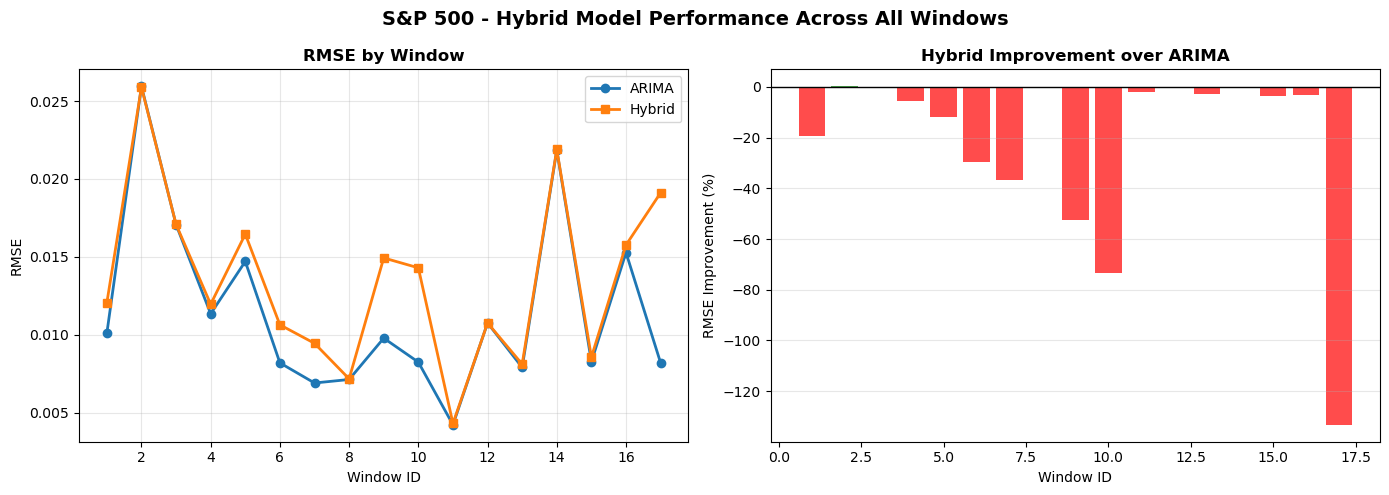


S&P 500 - SUMMARY STATISTICS
Total Windows: 17
Windows where Hybrid outperforms: 2
Windows where ARIMA outperforms: 15
Average Improvement: -22.04%
Best Improvement: 0.24% (Window 2)
Worst Improvement: -133.26% (Window 17)


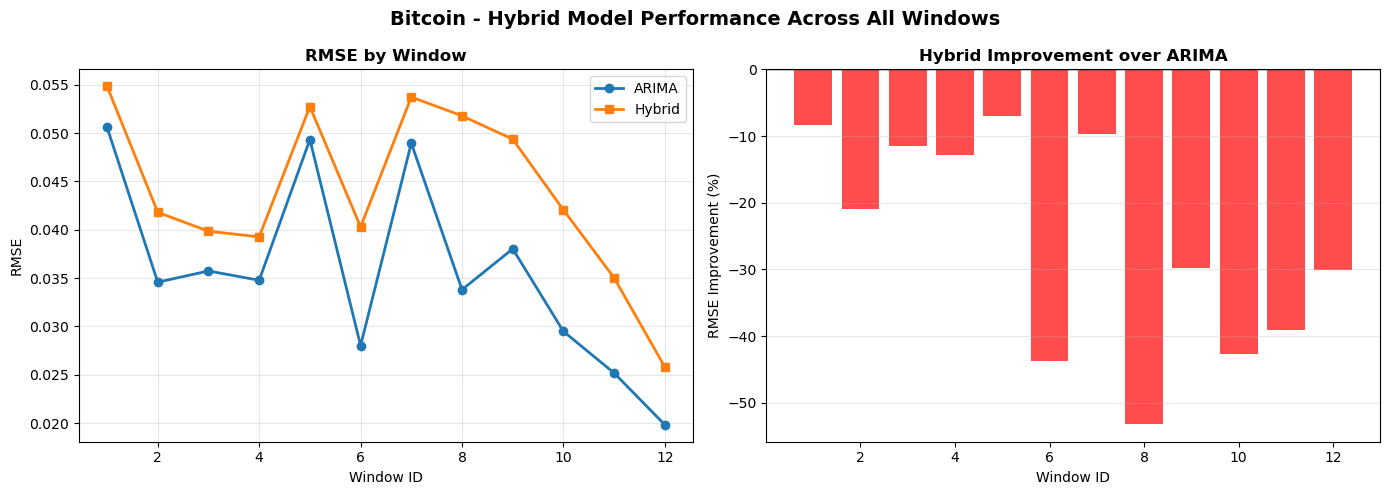


BITCOIN - SUMMARY STATISTICS
Total Windows: 12
Windows where Hybrid outperforms: 0
Windows where ARIMA outperforms: 12
Average Improvement: -25.74%
Best Improvement: -6.93% (Window 5)
Worst Improvement: -53.17% (Window 8)


In [17]:
plot_all_windows_comparison(sp500_hybrid_results)
plot_all_windows_comparison(bitcoin_hybrid_results)

# EURUSD Dataset Analysis

## ARIMA + SVM Hybrid
Dataset: EUR/USD Exchange Rate (2009-08-11 to 2019-08-11)

In [18]:
# Download EURUSD data
print("Downloading EURUSD data...")
eurusd_data = yf.download("EURUSD=X", start="2009-08-11", end="2019-08-11", progress=False)

print(f"\nEURUSD Data Shape: {eurusd_data.shape}")
print(f"EURUSD Date Range: {eurusd_data.index.min()} to {eurusd_data.index.max()}")
print(f"Total EURUSD observations: {len(eurusd_data)}")

# Calculate log returns
eurusd_data['Log_Returns'] = np.log(eurusd_data['Close'] / eurusd_data['Close'].shift(1))

# Clean data
eurusd_clean = eurusd_data.dropna()

print(f"\nAfter cleaning: {len(eurusd_clean)} observations")
print(f"Mean daily return: {eurusd_clean['Log_Returns'].mean():.6f}")
print(f"Standard deviation: {eurusd_clean['Log_Returns'].std():.6f}")


EURUSD Data Shape: (2604, 5)
EURUSD Date Range: 2009-08-11 00:00:00 to 2019-08-09 00:00:00
Total EURUSD observations: 2604

After cleaning: 2603 observations
Mean daily return: -0.000090
Standard deviation: 0.005766


In [ ]:
from dateutil.relativedelta import relativedelta
from datetime import timedelta

def create_eurusd_cv_splits(data, start_date=None):
    if start_date is None:
        start_date = data.index.min()
    
    cv_splits = []
    window_start = start_date
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=2) - timedelta(days=1)
        
        # Validation periods (8, 16, 24 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=8) - timedelta(days=1)
        val2_end = val_start + relativedelta(months=16) - timedelta(days=1)
        val3_end = val_start + relativedelta(months=24) - timedelta(days=1)
        
        # Test period (6 months)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(months=6) - timedelta(days=1)
        
        # Check if we have enough data
        if test_end > data.index.max():
            break
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 8
                },
                {
                    'fold': 2,
                    'data': val2_data,
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 16
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 24
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 1 year
        window_start += relativedelta(years=1)
    
    return cv_splits

# Create EURUSD CV splits
eurusd_cv_splits = create_eurusd_cv_splits(eurusd_clean)



=== EURUSD Cross-Validation Setup ===
Total CV windows: 6

First window details:
  Train: 2009-08-12 to 2011-08-11 (522 obs)
  Val 1: 2011-08-12 to 2012-04-11 (174 obs)
  Test:  2013-08-12 to 2014-02-11 (131 obs)


In [20]:
print("\n\n New Dataset: EURUSD HYBRID ARIMA-SVM")

eurusd_hybrid_results = run_hybrid_arima_svm_cv(
    cv_splits=eurusd_cv_splits,
    data_clean=eurusd_clean,
    asset_name='EURUSD',
    max_p=3,
    max_d=1,
    max_q=3,
    lookback=10,
    kernel='rbf',
    C=1.0,
    epsilon=0.1,
    gamma='scale',
    verbose=True
)



 New Dataset: EURUSD HYBRID ARIMA-SVM

🔄 HYBRID ARIMA-SVM CROSS-VALIDATION: EURUSD
Architecture: METHOD 2 (Non-additive) - SVM(lagged_obs, ARIMA_pred) → Direct forecast
ARIMA space: p∈[0,3], d∈[0,1], q∈[0,3]
SVM config: lookback=10, kernel=rbf, C=1.0, epsilon=0.1
Total windows: 6
----------------------------------------------------------------------------------------------------

📊 Window 1/6
   Train: 2009-08-12 to 2011-08-11 (522 obs)
   Test:  2013-08-12 to 2014-02-11 (131 obs)
   [1/4] 📈 Fitting ARIMA model...
       ✓ Best ARIMA(0, 0, 0), AIC=-3681.48
   [2/4] 🔍 Extracting ARIMA fitted values...
       ✓ ARIMA predictions: mean=-0.000008, std=0.000000
   [3/4] 🤖 Training SVM with lagged observations + ARIMA predictions...
       ✓ SVM trained with 512 samples
   [4/4] 🎯 Generating hybrid forecasts...
   ✅ RESULTS:
       ARIMA only:  RMSE=0.003908, MAE=0.002982, Direction=44.6%
       HYBRID:      RMSE=0.004401, MAE=0.003526, Direction=44.6%
       Improvement: -12.62% RMSE

📊 W

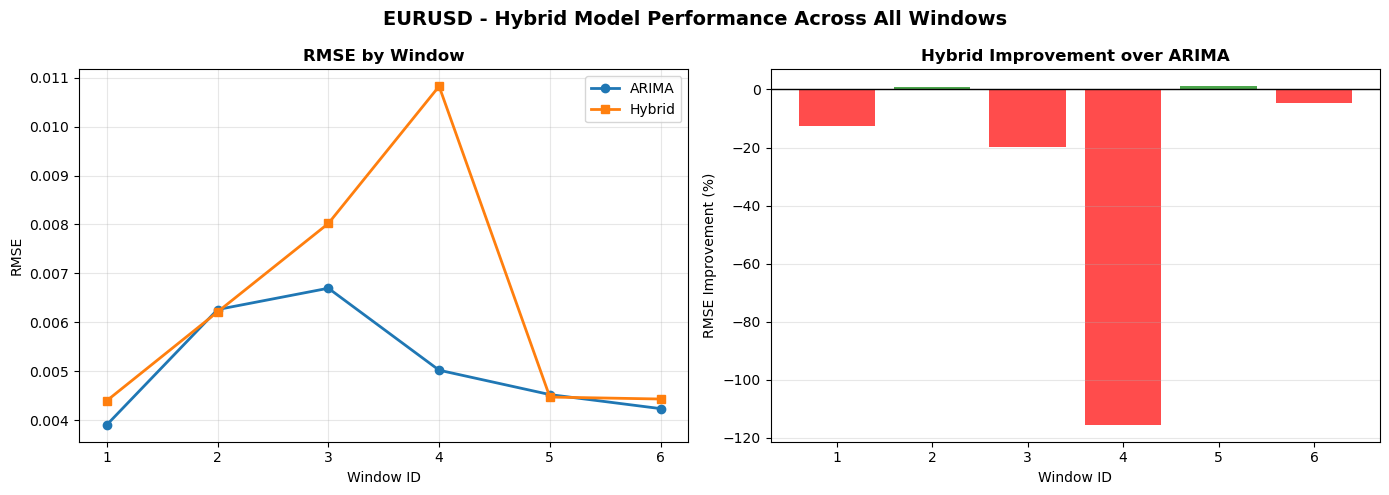


EURUSD - SUMMARY STATISTICS
Total Windows: 6
Windows where Hybrid outperforms: 2
Windows where ARIMA outperforms: 4
Average Improvement: -25.10%
Best Improvement: 1.11% (Window 5)
Worst Improvement: -115.47% (Window 4)


In [21]:
plot_all_windows_comparison(eurusd_hybrid_results)

# Trading Performance Metrics

In [23]:
def volatility_predictions_to_returns_new(predictions, true_values, actual_returns, transaction_costs=0.0):
    # Ensure all arrays have matching length
    min_len = min(len(predictions), len(true_values), len(actual_returns))
    predictions = predictions[:min_len]
    true_values = true_values[:min_len]
    actual_returns = (actual_returns.iloc[:min_len] 
                     if isinstance(actual_returns, pd.Series) 
                     else actual_returns[:min_len])
    
    # Convert to numpy arrays for consistency
    actual_returns_array = (actual_returns.values 
                           if isinstance(actual_returns, pd.Series) 
                           else actual_returns)

    signal = np.where(predictions > transaction_costs, 1, -1)

    if transaction_costs > 0.0:
        signals = np.where(np.abs(actual_returns_array) > transaction_costs, signal, 0)
    

    strategy_returns = signals * actual_returns_array

    return pd.Series(strategy_returns)

In [ ]:
def get_all_predictions(model_results, data_clean, model_type="S&P", window_indices=None):
    """
    Extract and aggregate returns from model cross-validation results.
    FIXED VERSION: Handles different structures for ARIMA vs LSTM/SVM.
    """

    if model_type == "S&P":
        cost = 0.005
    elif model_type == "Bitcoin":
        cost = 0.01
    else:
        cost = 0.001
    all_strategy_returns = []

    windows_to_use = model_results['window_results']
    if window_indices is not None:
        windows_to_use = [w for w in windows_to_use if w['window_id'] in window_indices]
    
    for window_result in windows_to_use:
        try:
            test_start = window_result['test_start']
            test_end = window_result['test_end']
            test_data = data_clean[test_start:test_end]
            
            predictions = window_result['hybrid_predictions']
            true_values = test_data['Log_Returns'].values[-len(predictions):]
            
            actual_returns = test_data['Log_Returns'].iloc[-len(predictions):]
            
            window_returns = volatility_predictions_to_returns_new(
                predictions, true_values, actual_returns.values, transaction_costs=cost
            )
            
            all_strategy_returns.append(window_returns)
            
        except Exception as e:
            print(f"  Warning: Failed to process window {window_result.get('window_id', '?')}: {str(e)}")
            continue
    
    # Concatenate all returns
    if all_strategy_returns:
        return pd.concat(all_strategy_returns, ignore_index=True)
    else:
        return pd.Series([])


# Trading Performance Metrics

In [ ]:
def annualized_return(daily_returns):
    cumulative = (1 + daily_returns).prod()
    n = daily_returns.shape[0]
    return cumulative ** (TRADING_DAYS / n) - 1


def annualized_std(daily_returns):
    return daily_returns.std() * np.sqrt(TRADING_DAYS)


def max_drawdown(daily_returns):
    equity = (1 + daily_returns).cumprod()
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    return np.abs(drawdown.min())  # Paper uses absolute value


def information_ratio(strategy_returns, benchmark_returns):
    arc = annualized_return(strategy_returns)
    asd = annualized_std(strategy_returns)
    
    if asd == 0:
        return np.nan
    return arc / asd


def modified_information_ratio(strategy_returns, benchmark_returns):
    arc = annualized_return(strategy_returns)
    asd = annualized_std(strategy_returns)
    md = max_drawdown(strategy_returns)
    
    if asd == 0 or md == 0:
        return np.nan
        
    return (arc * np.sign(arc) * arc) / (asd * md)


def sortino_ratio(daily_returns, risk_free_rate=0):
    negative_returns = daily_returns[daily_returns < 0]
    
    if len(negative_returns) == 0:
        return np.nan

    downside_std = np.std(negative_returns, ddof=1)
    asd_downside = downside_std * np.sqrt(TRADING_DAYS)
    
    arc = annualized_return(daily_returns)
    
    if asd_downside == 0:
        return np.nan
        
    return arc / asd_downside


def compute_performance_indicators(strategy_returns, benchmark_returns):
    return {
        "ARC": annualized_return(strategy_returns),
        "ASD": annualized_std(strategy_returns),
        "MD": abs(max_drawdown(strategy_returns)),
        "IR": information_ratio(strategy_returns, benchmark_returns),
        "IR*": modified_information_ratio(strategy_returns, benchmark_returns),
        "SR": sortino_ratio(strategy_returns)
    }



## S&P 500

In [ ]:
TRADING_DAYS = 232

# Get benchmark returns (Buy-and-Hold)
sp500_bnh_returns = sp500_clean['Log_Returns'].loc["2007-01-01":"2023-12-29"].values


sp500_hybrid_predictions = get_all_predictions(sp500_hybrid_results, sp500_clean)

sp500_hybrid_strategy_returns = sp500_hybrid_predictions

sp500_bnh_aligned = sp500_bnh_returns[-len(sp500_hybrid_strategy_returns):]

results_sp500 = []

# HYBRID
hybrid_metrics = compute_performance_indicators(
    pd.Series(sp500_hybrid_strategy_returns),
    pd.Series(sp500_bnh_aligned)
)
hybrid_metrics['Model'] = 'HYBRID'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(sp500_hybrid_strategy_returns > 0)) > 0))
results_sp500.append(hybrid_metrics)


table2_sp500 = pd.DataFrame(results_sp500)

print("TABLE: S&P 500 Long-Short Strategy Results")
print(table2_sp500[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_sp500.to_csv('table2_sp500.csv', index=False)



TABLE: S&P 500 Long-Short Strategy Results
 Model       ARC      ASD       MD        IR       IR*        SR
HYBRID -0.028121 0.193013 0.686426 -0.145693 -0.005969 -0.180363


## Bitcoin

In [ ]:
TRADING_DAYS = 345

# Get benchmark returns (Buy-and-Hold)
bitcoin_bnh_returns = bitcoin_clean['Log_Returns'].values

bitcoin_hybrid_predictions = get_all_predictions(bitcoin_hybrid_results, bitcoin_clean, model_type="bitcoin")

bitcoin_hybrid_strategy_returns = bitcoin_hybrid_predictions

bitcoin_bnh_aligned = bitcoin_bnh_returns[-len(bitcoin_hybrid_strategy_returns):]

results_bitcoin = []

# HYBRID
hybrid_metrics = compute_performance_indicators(
    pd.Series(bitcoin_hybrid_strategy_returns),
    pd.Series(bitcoin_bnh_aligned)
)
hybrid_metrics['Model'] = 'HYBRID'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(bitcoin_hybrid_strategy_returns > 0)) > 0))
results_bitcoin.append(hybrid_metrics)

table2_bitcoin = pd.DataFrame(results_bitcoin)

print("TABLE: Bitcoin Long-Short Strategy Results")
print(table2_bitcoin[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_bitcoin.to_csv('table2_bitcoin.csv', index=False)


TABLE: Bitcoin Long-Short Strategy Results
 Model      ARC      ASD       MD      IR      IR*       SR
HYBRID 0.331448 0.683482 0.663625 0.48494 0.242204 0.717473


## EURUSD

In [ ]:
TRADING_DAYS = 365

# Get benchmark returns (Buy-and-Hold)
eurusd_bnh_returns = eurusd_clean['Log_Returns'].values



eurusd_hybrid_predictions = get_all_predictions(eurusd_hybrid_results, eurusd_clean, model_type="EURUSD")

eurusd_hybrid_strategy_returns = eurusd_hybrid_predictions

eurusd_bnh_aligned = eurusd_bnh_returns[-len(eurusd_hybrid_strategy_returns):]


# Evaluate metrics directly (NO evaluate_model_longshort!)

results_eurusd = []

# HYBRID
hybrid_metrics = compute_performance_indicators(
    pd.Series(eurusd_hybrid_strategy_returns),
    pd.Series(eurusd_bnh_aligned)
)
hybrid_metrics['Model'] = 'HYBRID'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(eurusd_hybrid_strategy_returns > 0)) > 0))
results_eurusd.append(hybrid_metrics)

# Create TABLE 2
table2_eurusd = pd.DataFrame(results_eurusd)

print("TABLE: EURUSD Long-Short Strategy Results")
print(table2_eurusd[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_eurusd.to_csv('table2_eurusd.csv', index=False)



TABLE: EURUSD Long-Short Strategy Results
 Model      ARC      ASD       MD      IR      IR*       SR
HYBRID 0.029375 0.099538 0.133873 0.29511 0.064753 0.504343
